### Programming and critical analysis

Considering the `pd_speech.arff` dataset available, using `sklearn`, considering a 10-fold stratified cross validation (`random=0`), plot the cumulative testing confusion matrices of kNN (uniform weights, k = 5, Euclidean distance) and Naïve Bayes (Gaussian assumption). Use all remaining classifier parameters as default.

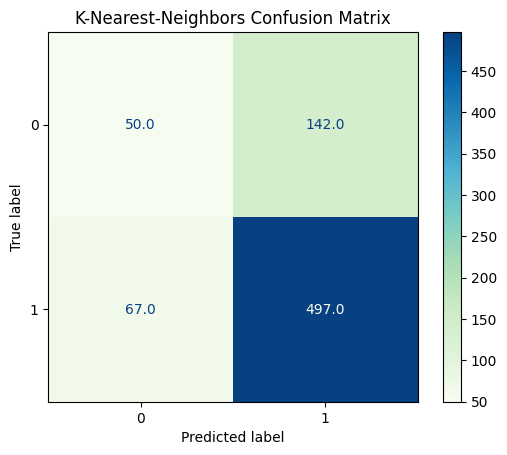

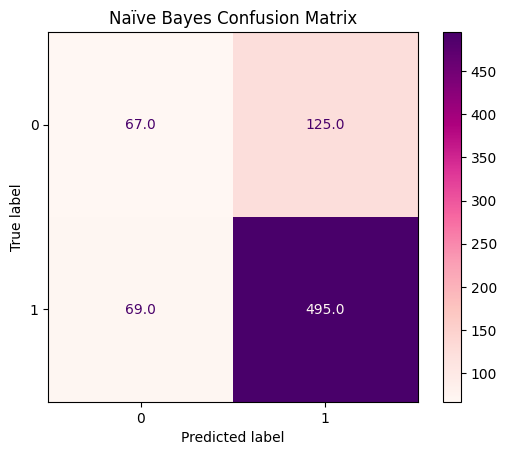

In [41]:
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Read the ARFF file and separate input from output data, to encode as numeric
data = loadarff('pd_speech.arff')
df = pd.DataFrame(data[0])
X = df.drop('class', axis=1)
y = LabelEncoder().fit_transform(df['class'])

# Create the stratified folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Create the classifiers and confusion matrices
knn = KNeighborsClassifier(n_neighbors=5, weights="uniform", metric='euclidean')
nb = GaussianNB()
knn_cm = np.zeros((2, 2))
nb_cm = np.zeros((2, 2))

# Iterate over the folds
for train_indexes, test_indexes in skf.split(X, y):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_indexes], X.iloc[test_indexes]
    y_train, y_test = y[train_indexes], y[test_indexes]
    # Fit the classifiers
    knn.fit(X_train, y_train)
    nb.fit(X_train, y_train)
    # Compute the confusion matrices based on the predicted output
    knn_cm += confusion_matrix(y_test, knn.predict(X_test))
    nb_cm += confusion_matrix(y_test, nb.predict(X_test))

# Plot the confusion matrices
disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
disp.plot(cmap="GnBu", values_format='')
disp.ax_.set_title("K-Nearest-Neighbors Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm)
disp.plot(cmap="RdPu", values_format='')
disp.ax_.set_title("Naïve Bayes Confusion Matrix")

Considering the `pd_speech.arff` dataset available, using `scipy`, test the hypothesis “kNN is statistically superior to Naïve Bayes regarding accuracy”, asserting whether is true.